# **Native PyTorch NPU**

# PyTorch version for Neural Networks with Hope,2017

Following notebook is based in the bibliography:

T. Hope, Y. S. Resheff, and I. Lieder, Learning TensorFlow: A Guide to Building Deep Learning Systems. Sebastopol, CA: O'Reilly Media, 2017.

**First Example**

Have installed an evironment for 
|OS      | Python | Pytorch  | NPU  |
|--------|--------|----------|------|
| Win11  | 3.10.19   | 2.10.0+cpu | 1.28.0 |

In order to check if NPU is  working, please run [NPU Test Bench] (./chapter-4/npu-TB.py)
In order to print a "Hello World!", we could use the classic Python code for that.
When Pytorch CPU+GPU is evoqued the training is handle, then NPU is evoqued for inference only.

*Still have bugs on CNN example and NPU is not fully functional*

In [ ]:
import sys
print("Python location:", sys.executable)
import numpy as np
import matplotlib
print("Numpy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
# --- PyTorch ---
import torch
print("PyTorch version:", torch.__version__)
print("CUDA:", torch.version.cuda)
# --- Intel NPU Acceleration Library ---
try:
    import intel_npu_acceleration_library as npu_lib
    from intel_npu_acceleration_library.backend import MatMul
    print("Intel NPU Acceleration Library: OK")
    npu_available = True
except Exception as e:
    print("Intel NPU Acceleration Library NOT found:", e)
    npu_available = False

print("Intel NPU available?", npu_available)

# --- Simple “Hello World” using PyTorch ---
h = torch.tensor(list(b"Hello"), dtype=torch.uint8)
w = torch.tensor(list(b" World!"), dtype=torch.uint8)
hw = torch.cat([h, w])
print(hw.numpy().tobytes().decode("utf-8"))

**Second Example**

Softmax Regression is a simple classifiers using tf environment. The nomenclature used is often $w_i^j$, where $w$ is a vector; $i$ is the indice of the vector; $j$ is the class that $w$ represents. Finally, $W$ is the database of $[w^a...w^z] \forall j \in [a,...,z]$ avaliable classes. This softmax regression is used to train MNIST benchmark, whgihc has 9 classes as follows. To train a neural network using MNIST data base and using softmax, one may transform the image $[28x28]$ into a flaten vector of $[1 x 784]$. Thus the position of the pixels (black or white) does not matter anymore in the training. Softmax neural network has 9 outputs, one for each class, and they store the probability to the input being from such class. The most probable class must be taken. See figure below:

<img src="../images/MNIST_dataset.png" alt="MNIST Dataset" width="700">


In [ ]:
%matplotlib inline
# ===============================================
# MNIST Training on CPU/GPU with optional NPU inference
# ===============================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from npu_callbacks import AccuracyPlotCallback, count_neurons_and_synapses
import numpy as np

# ================= NPU Detection ===================
try:
    import intel_npu_acceleration_library.backend as npu_backend
    npu_available = True
    print("Intel NPU detected for inference acceleration.")
except ImportError:
    npu_available = False
    print("Intel NPU not available. Running CPU/GPU only.")

# ================= Dataset ========================
transform = transforms.ToTensor()
train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

# ================= Model ==========================
class MNISTLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(784, 10)

    def forward(self, x, use_npu=False):
        x = self.flatten(x)
        if use_npu and npu_available:
            # Offload linear matmul to NPU
            X = x.detach().cpu().numpy().astype(np.float16)
            W = self.fc.weight.detach().cpu().numpy().astype(np.float16)
            b = self.fc.bias.detach().cpu().numpy().astype(np.float16)
            mm = npu_backend.MatMul(W.shape[1], W.shape[0], X.shape[0])
            y = mm.run(X, W) + b
            return torch.tensor(y, dtype=torch.float32)
        else:
            return self.fc(x)

model = MNISTLinear()

# Use CPU or GPU for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ================= Optimizer & Loss =================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# ================= Callback =================
callback = AccuracyPlotCallback()

# ================= Training Loop ===================
EPOCHS = 5
for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)  # regular PyTorch linear (autograd works)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

        train_correct += (logits.argmax(1) == yb).sum().item()
        train_total += xb.size(0)

    train_acc = train_correct / train_total

    # --- Validation (with optional NPU acceleration) ---
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            # Use NPU for inference if available
            logits = model(xb, use_npu=True)
            val_correct += (logits.argmax(1) == yb).sum().item()
            val_total += xb.size(0)

    val_acc = val_correct / val_total

    # --- Callback ---
    callback.on_epoch_end(epoch, train_acc, val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# ================= Final Evaluation =================
print("\nFinal evaluation (NPU inference if available):")
model.eval()
val_correct, val_total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb, use_npu=True)
        val_correct += (logits.argmax(1) == yb).sum().item()
        val_total += xb.size(0)
final_acc = val_correct / val_total
print("Test Accuracy:", final_acc)

# ================= Count neurons & synapses =========
count_neurons_and_synapses(model)

# Supervised Learning and the Train/Test Scheme

Supervised learning generally refers to the task of learning a function from data objects to labels associated with them, based on a set of examples where the correct labels are already known. This is usually subdivided into the case where labels are continuous (regression) or discrete (classification). 

The purpose of training supervised learning models is almost always to apply them later to new examples with unknown labels called inference phase, in order to obtain predicted labels for them. In the MNIST case discussed in this section, the purpose of training the model would probably be to apply it on new handwritten digit images and automatically find out what digits they represent.

As a result, we are interested in the extent to which our model will label new examples correctly. This is reflected in the way we evaluate the accuracy of the model. We first partition the labeled dataset into train and test partitions. During model training, we use only the train partition, and during validation we test the accuracy only on the test partition. This scheme is generally known as a train/test validation.

The actual training of the model, in the stochastic gradient descent (SGD) approach, consists of taking many steps in “the right direction.” The SGD optimizer used in this example is Adam. The cost function used is a cross entropy pre-defined fuction. The metric is the model accuracy, which is plotted during training and validation. 

In this example,we learn what is a epoch and a batch_size. To correclty define them, we have found.
An epoch is one full pass over the entire training dataset. The number of epochs affects:

✅ Training Time:

- More epochs = longer training time.
- Too many epochs can lead to overfitting, where the model memorizes the training data instead of generalizing.

✅ Model Performance:

- 5 epochs is often enough for simple datasets like MNIST because the softmax classifier is relatively simple.
- More complex models may require more epochs to learn complex patterns.
- If accuracy is low after 5 epochs, increasing the number of epochs (e.g., 10 or 20) can improve performance.

🚀 How to choose the right number of epochs?
Use early stopping to stop training when the validation accuracy stops improving. Example:
```python
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])
```

The batch size determines how many training samples are processed before updating the model's weights.

✅ Effect on Memory:

- A larger batch size (e.g., 128, 256) requires more GPU/CPU memory but speeds up training.
- A smaller batch size (e.g., 16 or 32) takes longer but uses less memory.

✅ Effect on Model Performance:

- Smaller batch sizes (e.g., 32, 64) → More stable updates, better generalization.
- Larger batch sizes (e.g., 128, 256) → Faster training but may generalize worse.

🚀 How to choose the right batch size?

-  32 or 64 is a good starting point for most problems. <- Golden Number from Rule of Thumb
- If training is slow, increase batch size (but check GPU memory usage).
- If results fluctuate a lot, try smaller batch sizes (e.g., 16).

The result is a neural network model described as:
- Input Layer: 784 neurons (flattened 28×28 images)
- Dense Output Layer: 10 neurons (softmax activation for classification)
- This is a fully connected layer, every input neuron connects to every neuron in the next layer:

$Synapses=Input Neurons×Output Neurons+Bias Terms$

$Synapses=(784×10)+10=7850$

[ Input Layer ] →  [ Dense Layer (784 neurons) ] → [ Output Layer (10 neurons, softmax) ]

<img src="../images/model_architecture.png" alt="NN model" width="700">


# Defining a Linear Graph for a Neural Network

We have some target variable y, which we want to explain using some feature vector
x. To do so, we first choose a model that relates the two. Our training data points will
be used for “tuning” the model so that it best captures the desired relation. In the fol‐
lowing chapters we focus on deep neural network models, but for now we will settle
for a simple regression problem.
Let’s start by describing our regression model:

$f(x_i) = w^Tx_i +b$

$y_i = f(x_i) +\epsilon_i$

$f(x_i)$ is assumed to be a linear combination of some input data xi, with a set of
weights $w$ and an intercept $b$. Our target output $y_i$ is a noisy version of $f(x_i)$ after being
summed with Gaussian noise $\epsilon_i$ (where $i$ denotes a given sample).

# What is a Loss Function ?
It a good measure with which we can evaluate the model’s performance.To capture the discrepancy between our model’s predictions and the observed targets, we need a measure reflecting “distance.” This distance is often referred to as an objective or a loss function, and we optimize the model by finding the set of parameters (weights and bias in this case) that minimize it.

Perhaps the most commonly used loss is the MSE (mean squared error), where for all
samples we average the squared distances between the real target and what our model
predicts across samples:

$L(y, \hat{y}) = \frac {1}{n} \sum^{n}_{i=1}\left( y_i - \hat{y}_i\right)^2$

Which turns in Python to:
```python
loss = tf.reduce_mean(tf.square(y_true-y_pred))
```

Another very common loss, especially for categorical data, is the cross entropy, which
we used in the softmax classifier in the previous chapter. The cross entropy is given
by

$H(p,q) = - \sum_x p(x)\log{q(x)}$

and for classification with a single correct label (as is the case in an overwhelming
majority of the cases) reduces to the negative log of the probability placed by the classifier on the correct label.

Which turns in Python to:
```python
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
loss = tf.reduce_mean(loss)
```

Cross entropy is a measure of similarity between two distributions. Since the classifi‐
cation models used in deep learning typically output probabilities for each class, we
can compare the true class (distribution $p$) with the probabilities of each class given
by the model (distribution $q$). The more similar the two distributions, the smaller our
cross entropy will be.

# Gradient Descent Optimizer: how to train neural networks?

While in some cases it is possible to find the global minimum analytically (when it exists), in
the great majority of cases we will have to use an optimization algorithm. Optimizers
update the set of weights iteratively in a way that decreases the loss over time.

*Lemma:*

So if $\hat{w}_1 = \hat{w}_0-\gamma \nabla F(\hat{w}_0)$ where $\nabla F(\hat{w}_0)$ is the gradient of $F$ evaluated at $\hat{w}_0$, then for a
small enough $\gamma$:

$F(\hat{w}_0) \geq F(\hat{w}_1)$

While convergence to the global minimum is guaranteed for convex functions, for nonconvex problems
(which are essentially all problems in the world of deep learning) they can get stuck
in local minima. In practice, this is often good enough, as is evidenced by the huge
success of the field of deep learning.

A more popular technique is the *stochastic gradient descent (SGD)*, where instead of
feeding the entire dataset to the algorithm for the computation of each step, a subset
of the data is sampled sequentially. The number of samples ranges from one sample at
a time to a few hundred, but the most common sizes are between around 50 to
around 500 (usually referred to as mini-batches).

Using smaller batches usually works faster, and the smaller the size of the batch, the
faster are the calculations. However, there is a trade-off in that small samples lead to
lower hardware utilization and tend to have high variance, causing large fluctuations
to the objective function. Nevertheless, it turns out that some fluctuations are benefi‐
cial since they enable the set of parameters to jump to new and potentially better local
minima. Using a relatively smaller batch size is therefore effective in that regard, and
is currently overall the preferred approach.

An important parameter to set is the algorithm’s learning rate, determining how
aggressive each update iteration will be (or in other words, how large the step will be
in the direction of the negative gradient). We want the decrease in the loss to be fast
enough on the one hand, but on the other hand not large enough so that we over-
shoot the target and end up at a point with a higher value of the loss function.

**Fourth Example: linear regression.**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# ===============================
# Matplotlib config
# ===============================
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False
})

# ===============================
# Detect Intel NPU Backend
# ===============================
try:
    import intel_npu_acceleration_library.backend as npu_backend
    NPU_AVAILABLE = True
    print("Intel NPU backend detected (inference only).")
except ImportError:
    NPU_AVAILABLE = False
    print("Intel NPU not available.")

# ===============================
# Device (CPU/GPU for training)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# Model Definition
# ===============================
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)

    def forward(self, x, use_npu=False):
        if use_npu and NPU_AVAILABLE:
            # NPU inference path (NO autograd here)
            X = x.detach().cpu().numpy().astype(np.float16)
            W = self.linear.weight.detach().cpu().numpy().astype(np.float16)
            b = self.linear.bias.detach().cpu().numpy().astype(np.float16)

            batch = X.shape[0]
            in_features = W.shape[1]
            out_features = W.shape[0]

            mm = npu_backend.MatMul(in_features, out_features, batch)
            y = mm.run(X, W.T)
            y += b

            return torch.tensor(y, dtype=torch.float32, device=x.device)
        else:
            return self.linear(x)

# Instantiate model
model = SimpleLinearModel().to(device)

# ===============================
# Dataset (same as TF example)
# ===============================
x_train = torch.tensor([
    [1.,2.,3.],
    [4.,5.,6.],
    [7.,8.,9.],
    [2.,3.,4.]
], dtype=torch.float32).to(device)

y_true = torch.tensor([
    [4.],
    [10.],
    [16.],
    [6.]
], dtype=torch.float32).to(device)

# ===============================
# Loss & Accuracy
# ===============================
def compute_loss(y_true, y_pred):
    return torch.mean((y_pred - y_true) ** 2)

def compute_accuracy(y_true, y_pred):
    abs_percentage_error = torch.abs((y_pred - y_true) / y_true)
    mape = torch.mean(abs_percentage_error)
    accuracy = 1 - mape
    return torch.clamp(accuracy, 0, 1)

# ===============================
# Optimizer
# ===============================
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

epochs = 300
loss_values = []
accuracy_values = []

# ===============================
# Training Loop (CPU/GPU)
# ===============================
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    y_pred = model(x_train, use_npu=False)  # PURE PyTorch training
    loss = compute_loss(y_true, y_pred)
    accuracy = compute_accuracy(y_true, y_pred)

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        loss_values.append(loss.item())
        accuracy_values.append(accuracy.item())
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Accuracy: {accuracy.item():.6f}")

# ===============================
# Plot Loss
# ===============================
plt.figure()
plt.plot(range(0, epochs, 50), loss_values, marker='o')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ===============================
# Plot Accuracy
# ===============================
plt.figure()
plt.plot(range(0, epochs, 50), accuracy_values, marker='*')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ===============================
# Final Evaluation (Optional NPU)
# ===============================
model.eval()
with torch.no_grad():
    y_pred_final = model(x_train, use_npu=True)  # NPU inference path

final_loss = compute_loss(y_true, y_pred_final)
final_accuracy = compute_accuracy(y_true, y_pred_final)

print(f"\nFinal Loss: {final_loss.item():.6f}")
print(f"Final Accuracy: {final_accuracy.item():.6f}")


**Fifth Example: logistic regression**

Here, the linear component $f(x_i) = w^Tx_i +b$ is the input of a nonlinear function called the logistic
function described as 

$P_r\left(y_i=1|x_i\right) = \frac{1}{1+ e^{wx_i +b}}$

We then regard these values as probabilities from which binary yes/1 or no/0 outcomes are generated. This is the nondeterministic (noisy) part of the model.
The logistic function is more general, and can be used with a different set of parameters for the steepness of the curve and its maximum value. This special case of a logistic function we are using is also referred to as a sigmoid function.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# ===============================
# Matplotlib config
# ===============================
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False  # safer unless LaTeX fully installed
})

# ===============================
# Detect Intel NPU backend
# ===============================
try:
    import intel_npu_acceleration_library.backend as npu_backend
    NPU_AVAILABLE = True
    print("Intel NPU backend detected (inference only).")
except ImportError:
    NPU_AVAILABLE = False
    print("Intel NPU not available.")

# ===============================
# Device for training
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# Model Definition
# ===============================
class SimpleSigmoidModel(nn.Module):
    def __init__(self, input_dim=3, output_dim=1):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_npu=False):
        if use_npu and NPU_AVAILABLE:
            # NPU inference path (detach, no gradient)
            X = x.detach().cpu().numpy().astype(np.float16)
            W = self.linear.weight.detach().cpu().numpy().astype(np.float16)
            b = self.linear.bias.detach().cpu().numpy().astype(np.float16)

            batch = X.shape[0]
            in_features = W.shape[1]
            out_features = W.shape[0]

            mm = npu_backend.MatMul(in_features, out_features, batch)
            y = mm.run(X, W.T)
            y += b

            return torch.sigmoid(torch.tensor(y, dtype=torch.float32, device=x.device))
        else:
            logits = self.linear(x)
            return torch.sigmoid(logits)

# Instantiate model
model = SimpleSigmoidModel().to(device)

# ===============================
# Dataset
# ===============================
x_train = torch.tensor([[1.,2.,3.],
                        [4.,5.,6.]], dtype=torch.float32).to(device)
y_true = torch.tensor([[0.7],
                       [0.9]], dtype=torch.float32).to(device)

# Optional noise for training
noise = torch.tensor(np.random.randn(2,1)*0.1, dtype=torch.float32).to(device)

# ===============================
# Loss & Accuracy
# ===============================
bce_loss = nn.BCELoss()  # Binary cross-entropy

def compute_loss(y_true, y_pred):
    return bce_loss(y_pred, y_true)

def compute_accuracy(y_true, y_pred):
    abs_percentage_error = torch.abs((y_pred - y_true) / y_true)
    mape = torch.mean(abs_percentage_error)
    accuracy = 1 - mape
    return torch.clamp(accuracy, 0, 1)

# ===============================
# Optimizer
# ===============================
learning_rate = 0.002
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

epochs = 400
loss_values = []
accuracy_values = []

# ===============================
# Training Loop
# ===============================
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(x_train) + noise  # keep noise during training
    loss = compute_loss(y_true, y_pred)
    accuracy = compute_accuracy(y_true, y_pred)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        loss_values.append(loss.item())
        accuracy_values.append(accuracy.item())
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Accuracy: {accuracy.item():.6f}")

# ===============================
# Plot Loss
# ===============================
plt.figure()
plt.plot(range(0, epochs, 20), loss_values, marker='o')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ===============================
# Plot Accuracy
# ===============================
plt.figure()
plt.plot(range(0, epochs, 20), accuracy_values, marker='*')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ===============================
# Final Evaluation (Optional NPU)
# ===============================
model.eval()
with torch.no_grad():
    y_pred_final = model(x_train, use_npu=True)
final_loss = compute_loss(y_true, y_pred_final)
final_accuracy = compute_accuracy(y_true, y_pred_final)

print(f"\nFinal Loss: {final_loss.item():.6f}")
print(f"Final Accuracy: {final_accuracy.item():.6f}")


# What is Convolutional Neural Networks ?
 (...)
 
**Sixth Example MNIST Take II using CNNs**


In [ ]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

from npu_callbacks import NpuLinear, AccuracyPlotCallback, count_neurons_and_synapses

# ===============================
# Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# Define CNN Model (PyTorch)
# ===============================
class MNISTNpuCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # padding='same'
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = NpuLinear(64 * 7 * 7, 1024)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = NpuLinear(1024, 10)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, use_npu=False):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        if use_npu:
            # Optional NPU inference (no gradient)
            if torch.is_grad_enabled():
                with torch.no_grad():
                    return self.softmax(x)
            else:
                return self.softmax(x)
        else:
            return self.softmax(x)

# Instantiate model
model = MNISTNpuCNN().to(device)

# ===============================
# Dataset
# ===============================
transform = transforms.ToTensor()
train_ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Convert labels to one-hot
def one_hot(y, num_classes=10):
    return torch.nn.functional.one_hot(y, num_classes=num_classes).float()

# ===============================
# Loss and Optimizer
# ===============================
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ===============================
# Callback
# ===============================
callback = AccuracyPlotCallback()

# ===============================
# Training Loop
# ===============================
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

        train_correct += (logits.argmax(1) == yb).sum().item()
        train_total += xb.size(0)

    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb, use_npu=True)  # NPU inference
            val_correct += (logits.argmax(1) == yb).sum().item()
            val_total += xb.size(0)
    val_acc = val_correct / val_total

    callback.on_epoch_end(epoch, train_acc, val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# ===============================
# Final Evaluation
# ===============================
count_neurons_and_synapses(model)



# CIFAR10
CIFAR10 is another dataset with a long history in computer vision and machine
learning. Like MNIST, it is a common benchmark that various methods are tested
against. CIFAR10 is a set of 60,000 color images of size 32×32 pixels, each belonging
to one of ten categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship,
and truck.

State-of-the-art deep learning methods for this dataset are as good as humans at classifying these images. In this section we start off with much simpler methods that will
run relatively quickly. Then, we discuss briefly what the gap is between these and the
state of the art.

Proposed neural network model consists of three blocks of convolutional layers, followed by the fully connected and output layers we have already seen a few times before. Each block of convolutional layers contains three consecutive convolutional layers, followed by a single pooling and dropout. This model is still compact
and fast, and achieves approximately 83% accuracy after ~15 epochs. However, there is some overfitting as this accuracy is not found during testing phase.

**$7^{th}$ Example CIFAR10**

Please restart the Jupyter notebook to clean the used memory and run only this example after that.

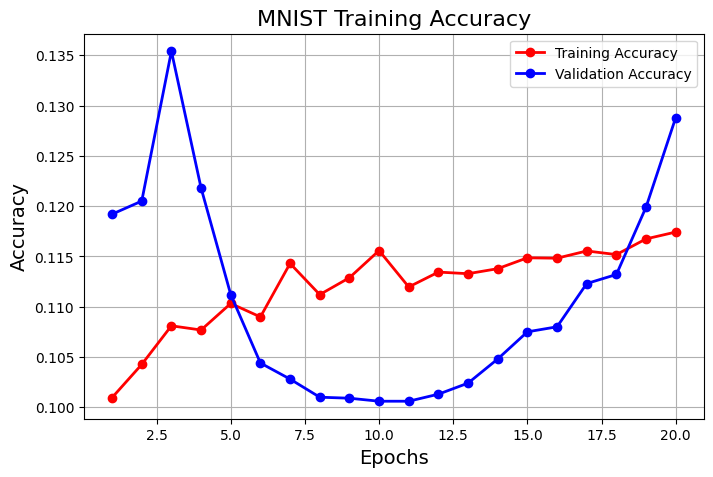

Epoch 20/20 - Train Acc: 0.1174 | Val Acc: 0.1288

--- Model Summary (Neurons and Synapses) ---
fc1 | Linear | Neurons: 500, Synapses: 40500
fc2 | Linear | Neurons: 10, Synapses: 5010
Total neurons: 510, Total synapses: 45510


In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

from npu_callbacks import NpuLinear, AccuracyPlotCallback, count_neurons_and_synapses

# ===============================
# Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# Data Preprocessing (CIFAR-10)
# ===============================
# Training transformations (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

# Testing transformations
test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset
train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

# ===============================
# CIFAR-10 CNN Model
# ===============================
class CIFARNpuCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutions
        self.conv1 = nn.Conv2d(3, 30, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(30, 50, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(50, 80, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(8, 8)  # big pooling

        self.flatten = nn.Flatten()
        # Fully connected layers with NPU support
        self.fc1 = NpuLinear(80 * 1 * 1, 500)  # 8x8 pooling -> 1x1 feature map
        self.dropout = nn.Dropout(0.8)
        self.fc2 = NpuLinear(500, 10)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, use_npu=False):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        if use_npu:
            # Optional NPU inference
            if torch.is_grad_enabled():
                with torch.no_grad():
                    return self.softmax(x)
            else:
                return self.softmax(x)
        else:
            return self.softmax(x)

# Instantiate model
model = CIFARNpuCNN().to(device)

# ===============================
# Loss and Optimizer
# ===============================
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# ===============================
# Callback
# ===============================
callback = AccuracyPlotCallback()

# ===============================
# Training Loop
# ===============================
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

        train_correct += (logits.argmax(1) == yb).sum().item()
        train_total += xb.size(0)

    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb, use_npu=True)  # NPU inference
            val_correct += (logits.argmax(1) == yb).sum().item()
            val_total += xb.size(0)
    val_acc = val_correct / val_total

    callback.on_epoch_end(epoch, train_acc, val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# ===============================
# Final Evaluation
# ===============================
count_neurons_and_synapses(model)


# Recurrent Neural Networks

It is powerful class of deep learning algorithms particularly useful and popular in natural language processing. Besides, RNN is an immensely important and useful type of neural network to process sequential structures. The type of data with strong sequential structure is natural language. That's why RNN is often employed in a supervised text classification
problem with word-embedding training.

The basic idea behind RNN models is that each new element in the sequence contributes some new information, which updates
the current state of the model. A fundamental mathematical construct in statistics and probability, which is often
used as a building block for modeling sequential patterns via machine learning is the
Markov chain model. RNN applies some form of “loop” to deal with such sequency of information. This is very related to the Markov chain models discussed previously and their
hidden Markov model (HMM) extensions, which are not discussed here.

The update step for our simple vanilla RNN is

$h_t = tanh(W_x x_t + W_h h_{t-1} + b)$

where $W_h$, $W_x$, and $b$ are weight and bias variables we learn, $tanh(·)$ is the hyperbolic
tangent function.

While the structure of natural images is
well suited for CNN models, it is revealing to look at the structure of images from
different angles. In a trend in cutting-edge deep learning research, advanced models
attempt to exploit various kinds of sequential structures in images, trying to capture
in some sense the “generative process” that created each image. Intuitively, this all
comes down to the notion that nearby areas in images are somehow related, and trying to model this structure. We assume that the last state vector has “accumulated” information representing the entire sequence.

Following example builds a vanilla RNN example. The model we defined is composed of two main layers:
1. **VanillaRNNLayer**  
   - A custom layer that processes the input sequence over 28 time steps.
   - For each time step, it updates a hidden state of size 128 using the recurrence:
    
    $h_t = tanh(W_x x_t + W_h h_{t-1} + b)$

    where:
    - $W_h$ (hidden-to-hidden weights) has a shape of \([128, 128]\).
    - $W_x$ (input-to-hidden weights) maps the input vector (of size 28) to a hidden state vector of size **128**.
    - $b$ is the bias term.

   - This layer encapsulates the recurrent processing logic using the parameters:
     - `element_size` (input dimension per time step)
     - `time_steps` (length of the sequence)
     - `hidden_layer_size` (size of the hidden state)

2. **Dense Layer**  
   - A fully connected layer that takes the final hidden state (size 128) as input.
   - It produces **num_classes = 10** logits for classification.



The **VanillaRNNLayer** is designed with a hidden state of size **128** (`hidden_layer_size = 128`). This means that at every time step, the hidden state vector \( h_t \) has **128 values**. Each value represents a neuron in the recurrent layer. Because the hidden state $h_t$ is of size **128**, this confirms that the recurrent layer effectively contains **128 neurons**.

Thus, the recurrent layer in your model indeed has **128 neurons**. This layer is followed by a fully connected layer of **10 neurons**, which produces the **10** output logits required for a MNIST classification.

**$8^{th}$ Example MNIST classification using a vanilla RNN**

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from callbackPlots import AccuracyPlotCallback

# Parameters
element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape dataset for RNNs
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, time_steps, element_size)  
x_test = x_test.reshape(-1, time_steps, element_size)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Create dataset batches
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


# Define a custom vanilla RNN model using subclassing
class VanillaRNNLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_layer_size, **kwargs):
        super(VanillaRNNLayer, self).__init__(**kwargs)
        self.hidden_layer_size = hidden_layer_size

    def build(self, input_shape):
        element_size = input_shape[-1]  # Get element size dynamically

        # Define Weights and Biases
        self.Wx = self.add_weight(name="Wx", shape=(element_size, self.hidden_layer_size),
                                  initializer='random_normal', trainable=True)
        self.Wh = self.add_weight(name="Wh", shape=(self.hidden_layer_size, self.hidden_layer_size),
                                  initializer='random_normal', trainable=True)
        self.b_rnn = self.add_weight(name="b_rnn", shape=(self.hidden_layer_size,),
                                     initializer='zeros', trainable=True)
        super(VanillaRNNLayer, self).build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]  # Dynamically get time steps

        hidden_state = tf.zeros([batch_size, self.hidden_layer_size])

        for t in range(time_steps):
            x_t = inputs[:, t, :]
            hidden_state = tf.tanh(
                tf.matmul(hidden_state, self.Wh) +
                tf.matmul(x_t, self.Wx) +
                self.b_rnn
            )

        return hidden_state

class VanillaRNN(tf.keras.Model):
    def __init__(self, hidden_layer_size, num_classes, **kwargs):
        super(VanillaRNN, self).__init__(**kwargs)
        self.rnn_layer = VanillaRNNLayer(hidden_layer_size)
        self.dense = tf.keras.layers.Dense(num_classes)  # No activation to keep logits

    def call(self, x):
        x = self.rnn_layer(x)
        logits = self.dense(x)
        return logits  # Return unnormalized scores (logits)


# Instantiate the model

vanilla_rnn_model = VanillaRNN(hidden_layer_size=hidden_layer_size, num_classes=num_classes)

# Optionally, build the model to see the summary:
vanilla_rnn_model.build(input_shape=(None, time_steps, element_size))

# Create the callback instance
plot_callback = AccuracyPlotCallback()

# Debugging: Print if the callback is created correctly
print(f"Callback created: {plot_callback}")

# Compile & Train
vanilla_rnn_model.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

vanilla_rnn_model.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=[plot_callback])

# Evaluate the model on the test set
test_loss, test_acc = vanilla_rnn_model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

vanilla_rnn_model.summary()


**$9^{th}$ Example MNIST classification Simple RNN from Keras**

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models
from callbackPlots import AccuracyPlotCallback
from callbackPlots import count_neurons_and_synapses

# Define some parameters
element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize images to [0,1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the dataset for RNNs
x_train = x_train.reshape(-1, time_steps, element_size)  # (batch, 28, 28)
x_test = x_test.reshape(-1, time_steps, element_size)


# Convert labels to categorical (if needed)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Create TensorFlow dataset for batching
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Define the model
model = models.Sequential([
    layers.SimpleRNN(hidden_layer_size, activation="tanh", input_shape=(time_steps, element_size)),
    layers.Dense(num_classes, activation="softmax")  # Fully connected output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],)  # Explicitly add metrics

# Create the callback instance
plot_callback = AccuracyPlotCallback()

# Debugging: Print if the callback is created correctly
print(f"Callback created: {plot_callback}")

# Train the model
model.fit(train_dataset, epochs=10, validation_data=test_dataset,callbacks=[plot_callback])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")
# Save the model in Keras format (.keras)
model_filename = f"model_Accu{test_acc:.4f}.keras"
model.save(model_filename)

# Model summary
model.summary() 